# Otto Kailing -- Vital Sign Data Sonification

## Setup

In [2]:
# Authors : Otto Kailing; Gian C. Rodríguez
# Based on work by : José Constantino Sánchez Curet

# Install the necessary things before importing
!pip install saxpy
!pip install playsound
!pip install simpleaudio

# Importing libraries and required packages
import numpy as np

from saxpy.znorm import znorm              # to normalize the time series
from saxpy.paa import paa                  # PAA
from saxpy.sax import ts_to_string         # to convert the time series to string
from saxpy.alphabet import cuts_for_asize  # alphabet size
# from saxpy.sax import sax_via_window       # for smaller SAX words -- not currently used

import matplotlib.pyplot as plt

import simpleaudio as sa                # sound playing package

import csv                 # to be able to import .csv (and our .dat) files
import pandas as pd        # for the readcsv function, to read in data

## Working with two files at once

In [29]:
# Starting with patient 40006 -- the same one I used last summer for just HR
HR = pd.read_csv("data/HR_a40006_1.dat", header = None)
MAP = pd.read_csv("data/MAP_a40006_1.dat", header = None)

# Convert both to array of floats
HR = HR[0]; MAP = MAP[0]

# Verify that they're both the same length
print("Length of HR file  =", len(HR), "\nLength of MAP file =", len(MAP))

Length of HR file  = 3865 
Length of MAP file = 3865


In [4]:
# Create backup of raw data
# !!!!!!!!!!!!! RERUNNING THIS CELL WILL DELETE THE BACKUP !!!!!!!!!!!!!
HR_raw = HR
MAP_raw = MAP

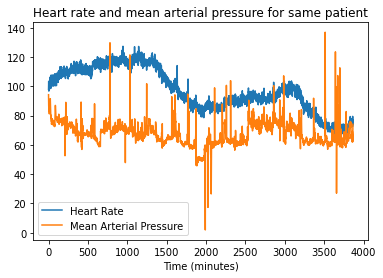

In [30]:
# Plot both raw files on the same plot
plt.plot(HR_raw, label = "Heart Rate")
plt.plot(MAP_raw, label = "Mean Arterial Pressure")
plt.title("Heart rate and mean arterial pressure for same patient")
plt.xlabel("Time (minutes)")
plt.legend()
plt.show()

In [45]:
# Normalize the data
HR = znorm(HR)
MAP = znorm(MAP)

# Define PAA size (divide by 80 is what Otto used in the summer 2020 project)
#  * We want same PAA size for both files, so they end up the same length too
#  * len(HR_raw) because this will not change. In contrast, the objects
#    "HR" and "MAP" are being reassigned at every step.
paa_size = int(len(HR_raw) / 80)
print("PAA size =", paa_size)

if (paa_size != 0):
    # Apply PAA to both files
    HR = paa(HR, paa_size)
    MAP = paa(MAP, paa_size)
    # NOTE: this should not cause any problems with rerunning. Asking to run a PAA
    # of the post-PAA data with the same size should just regenerate the same data.
    
    # Verify that they're both the same length
    print("\nPost PAA:\nLength of HR  =", len(HR), "\nLength of MAP =", len(MAP))
else:
    print("Error: PAA size is 0; cannot divide by 0")


PAA size = 48

Post PAA:
Length of HR  = 48 
Length of MAP = 48


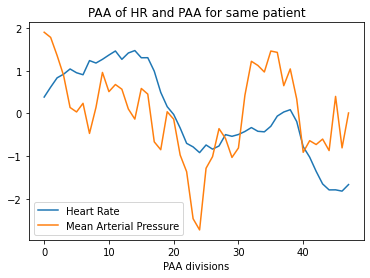

In [44]:
# Plot the files post PAA adjustment.
plt.plot(HR, label = "Heart Rate")
plt.plot(MAP, label = "Mean Arterial Pressure")
plt.title("PAA of HR and PAA for same patient")
plt.xlabel("PAA divisions")
plt.legend()
plt.show()

### Making SAX strings

In [47]:
# Define SAX alphabet size
asize = 8

# Create SAX strings of the two objects
HR_SAX = ts_to_string(HR, cuts_for_asize(asize))
MAP_SAX = ts_to_string(MAP, cuts_for_asize(asize))

# Prints the SAX strings
print("HR SAX: ", HR_SAX, "\nMAP SAX:", MAP_SAX)

HR SAX:  ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa 
MAP SAX: hhhgeeecegfgfedffcbedbaaaabccbbfhgghhfgfbcbcbfbe


# Next step: make 'em make sound!

# Shit from before
#### Making a "melody" function

Let's define a function for our generated melody, so that we don't have to write it out every time.

In [23]:
def melody(sax, black_box):
    if not black_box: print("Starting playback...")
    
    # Iterate through the characters
    for char in sax:
        # Print the current letter
        if not black_box: print(char, end="")
        
        # Test for each character and play the correct note
        if char == "a":
            sound = sa.WaveObject.from_wave_file("soundFiles/a_low.wav").play()
        elif char == "b":
            sound = sa.WaveObject.from_wave_file("soundFiles/b.wav").play()
        elif char == "c":
            sound = sa.WaveObject.from_wave_file("soundFiles/db.wav").play()
        elif char == "d":
            sound = sa.WaveObject.from_wave_file("soundFiles/d.wav").play()
        elif char == "e":
            sound = sa.WaveObject.from_wave_file("soundFiles/e.wav").play()
        elif char == "f":
            sound = sa.WaveObject.from_wave_file("soundFiles/gb.wav").play()
        elif char == "g":
            sound = sa.WaveObject.from_wave_file("soundFiles/ab.wav").play()
        elif char == "h":
            sound = sa.WaveObject.from_wave_file("soundFiles/a.wav").play()
        # Wait for each sound to finish before playing next one
        sound.wait_done()
    
    if not black_box: print("\nFinished!")

Now we can enact the function "melody" on our new SAX string.

Graph of data post-PAA:


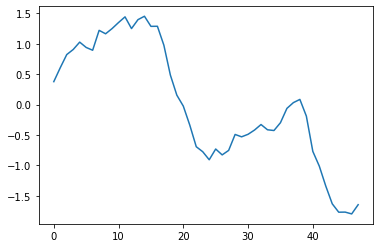

SAX string: ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa
Starting melody playback:
Finished!


In [24]:
print("Graph of data post-PAA:")
plt.plot(hr2_paa_1_25); plt.show()
print("SAX string:", hr2_sax_short)

# Calls the melody function on the new string
print("Starting melody playback:")
# # Commented out for not interrupting the demo
# melody(hr2_sax_short)
print("Finished!")

## Comparing different patients

The [PhysioNet contest](https://physionet.org/content/challenge-2009/1.0.0/) from which these data are taken (the "training" dataset) involved, as the title would suggest, "Predicting Acute Hypotensive Episodes." As such, the training data includes patients with and without periods of acute hypotension, as well as those who experienced hypotension before or after the data were collected. There are a wide variety of data. Hopefully we can see -- <em> and hear</em> -- as much.

### Function to do everything in one step

Below I will define a function for running the whole procedure (read in data --> znorm --> PAA --> SAX) on any given data file, and then another which adds the melody. (It's useful to be able to call your sound up on cue.)

In [25]:
# Take one of the data files and return the sax string
# - data_file: path to the .dat file from MIMIC II
# - black_box: FALSE if you want graphs and feedback displayed;
#              TRUE if, well, you don't.
def saxify(data_file, black_box):
    # Read in the data file.
    data = pd.read_csv(data_file, header = None)
    
    # Convert to a normal array of floats.
    hr_raw = data[0]
    
    # Graph the raw data (if desired)
    if not black_box:
        print("Raw data:")
        plt.plot(hr_raw)
        plt.show()       
    
    # Normalize
    hr_norm = znorm(hr_raw)
    
    # Apply PAA
    paa_size = len(hr_norm) // 80 # int(len(hr_norm) / paa_modifier)
    if not black_box: print("PAA size =", paa_size)
    hr_paa = paa(hr_norm, paa_size)
    # ... and graph if desired
    if not black_box:
        print("Smoothed data after PAA:"); plt.plot(hr_paa); plt.show()
    
    # Create SAX string
    hr_sax = ts_to_string(hr_paa, cuts_for_asize(8))
    # ... and display if desired
    if not black_box:
        print("SAX string:", hr_sax)
    
    # Returns the SAX string
    return hr_sax

# Just a function that calls saxify() and melody() in sequence.
def sonify(data_file, black_box):
    melody(saxify(data_file, black_box), black_box)

### Applying function to other datasets

In [26]:
# # Commented out for not interrupting the demo
# sonify("newImprovedData/HR_a40834_1.dat", black_box = False)

## Demo for presentation

Here I call saxify() and melody() separately.

Raw data:


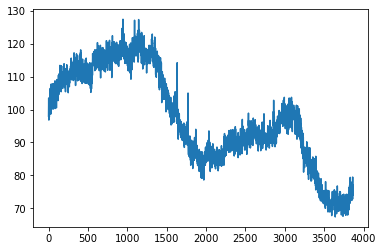

PAA size = 48
Smoothed data after PAA:


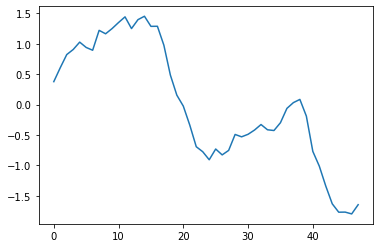

SAX string: ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa


In [27]:
sax_1 = saxify("newImprovedData/HR_a40006_1.dat", black_box = False)

In [29]:
melody(sax_1, black_box = False)

Starting playback...
ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa
Finished!


In [ ]:
sax_2 = saxify("newImprovedData/HR_a40834_1.dat", black_box = False)

In [ ]:
melody(sax_2, black_box = False)